In [312]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import signal as sp_signal
import scipy

plt.style.use('ggplot')

In [313]:
def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = sp_signal.resample(signal, num_samples)
    return resampled_signal

def equalize_length(signals):
    min_length = min(len(signal) for signal in signals)
    equalized_signals = [signal[:min_length] for signal in signals]
    return equalized_signals

def create_correlation_matrix(signals):
    corr_matrix = np.corrcoef(signals)
    corr_matrix[np.round(corr_matrix, 4) == 1] = np.nan
    return corr_matrix

def high_pass_filter(signal, samp_rate, cutoff_freq=40):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def get_file(path="database/train/drive01", sampfrom=0, n_samp=500, filter=True, do_sample=True):
    if do_sample:
        sig, sinfo = wfdb.rdsamp(path, sampfrom=sampfrom, sampto=sampfrom+n_samp)
    else:
        sig, sinfo = wfdb.rdsamp(path)
    sig = sig[:, 0].flatten()

    if filter:
        sig = high_pass_filter(sig, sinfo["fs"])

    sinfo["record_name"] = os.path.basename(path)

    dir_name, record_name = os.path.split(path)
    annotation_path = os.path.join(dir_name, f"{record_name}.atr")
    
    if os.path.isfile(annotation_path):
        if do_sample:
            ann = wfdb.rdann(path, extension='atr', sampfrom=sampfrom, sampto=sampfrom+n_samp)
        else:
            ann = wfdb.rdann(path, extension='atr')
        sinfo['annotation'] = ann
    else:
        sinfo['annotation'] = None

    return np.array(sig), sinfo

def detect_peaks(signal, p_threshold, min_distance=3, min_peak_height=0.01):
    threshold = np.percentile(signal, p_threshold)
    
    above_threshold = signal > threshold
    diff = np.diff(above_threshold.astype(int))
    rise = np.where(diff == 1)[0] + 1 
    fall = np.where(diff == -1)[0] + 1 
    
    if above_threshold[0]:
        rise = np.insert(rise, 0, 0)
    if above_threshold[-1]:
        fall = np.append(fall, len(signal))
    
    peaks = []
    peaks_values = []
    for start, end in zip(rise, fall):
        segment = signal[start:end]
        if len(segment) == 0:
            continue
        max_idx = np.argmax(segment)
        peak_idx = start + max_idx
        peaks.append(peak_idx)
        peaks_values.append(signal[peak_idx])
    
    if min_distance > 0:
        peaks = np.array(peaks)
        peaks_values = np.array(peaks_values)
        sorted_indices = np.argsort(peaks_values)[::-1]
        sorted_peaks = peaks[sorted_indices]
        
        filtered_peaks = []
        used = np.zeros(len(signal), dtype=bool)
        
        for peak in sorted_peaks:
            if used[peak]:
                continue
            start = max(0, peak - min_distance)
            end = min(len(signal), peak + min_distance + 1)
            if not used[start:end].any():
                filtered_peaks.append(peak)
                used[start:end] = True
        
        filtered_peaks = np.sort(filtered_peaks)
        peaks = filtered_peaks.tolist()
        peaks_values = signal[filtered_peaks].tolist()
    
    if min_peak_height is not None:
        peaks = [peak for peak in peaks if signal[peak] >= min_peak_height]
        peaks_values = [signal[peak] for peak in peaks]
    
    return np.array(peaks), np.array(peaks_values)

def load_train_data(folder="database/train", sampfrom=0, n_samp=500, filter=False,do_sample=True):
    signals = []
    infos = []

    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)

        if os.path.isfile(file_path) and file_name.startswith("drive") and file_name.endswith(".dat"):
            file_without_extension = os.path.splitext(file_name)[0]
            new_file_name = f"{folder}/{file_without_extension}"
            sig, sinfo = get_file(new_file_name, sampfrom=sampfrom, n_samp=n_samp, filter=filter, do_sample=do_sample)
            
            signals.append(sig)
            infos.append(sinfo)

    return signals, infos

def process_signals(signals, sampling_rates):
    highest_sr = sampling_rates[np.argmax(sampling_rates)]
    signals = [resample_signal(sig, fs, highest_sr) for sig, fs in zip(signals, sampling_rates)]
    signals = trim_to_peak(signals, 92)
    
    max_signal_size = min([s.size for s in signals])
    
    for i, (signal, signal_size) in enumerate(zip(signals, [s.size for s in signals])):
        if signal_size != max_signal_size:
            signals[i] = signal[:max_signal_size]
    
    return signals, highest_sr

def trim_to_peak(signals, p_threshold=95, min_distance=3, min_peak_height=0.01):
    processed_signals = []

    for signal in signals:
        rpeaks, _ = detect_peaks(
            signal,
            p_threshold=p_threshold,
            min_distance=min_distance,
            min_peak_height=min_peak_height,
        )

        first_rpeak = rpeaks[0]
        trimmed_signal = signal[first_rpeak:]

        processed_signals.append(trimmed_signal)

    return processed_signals

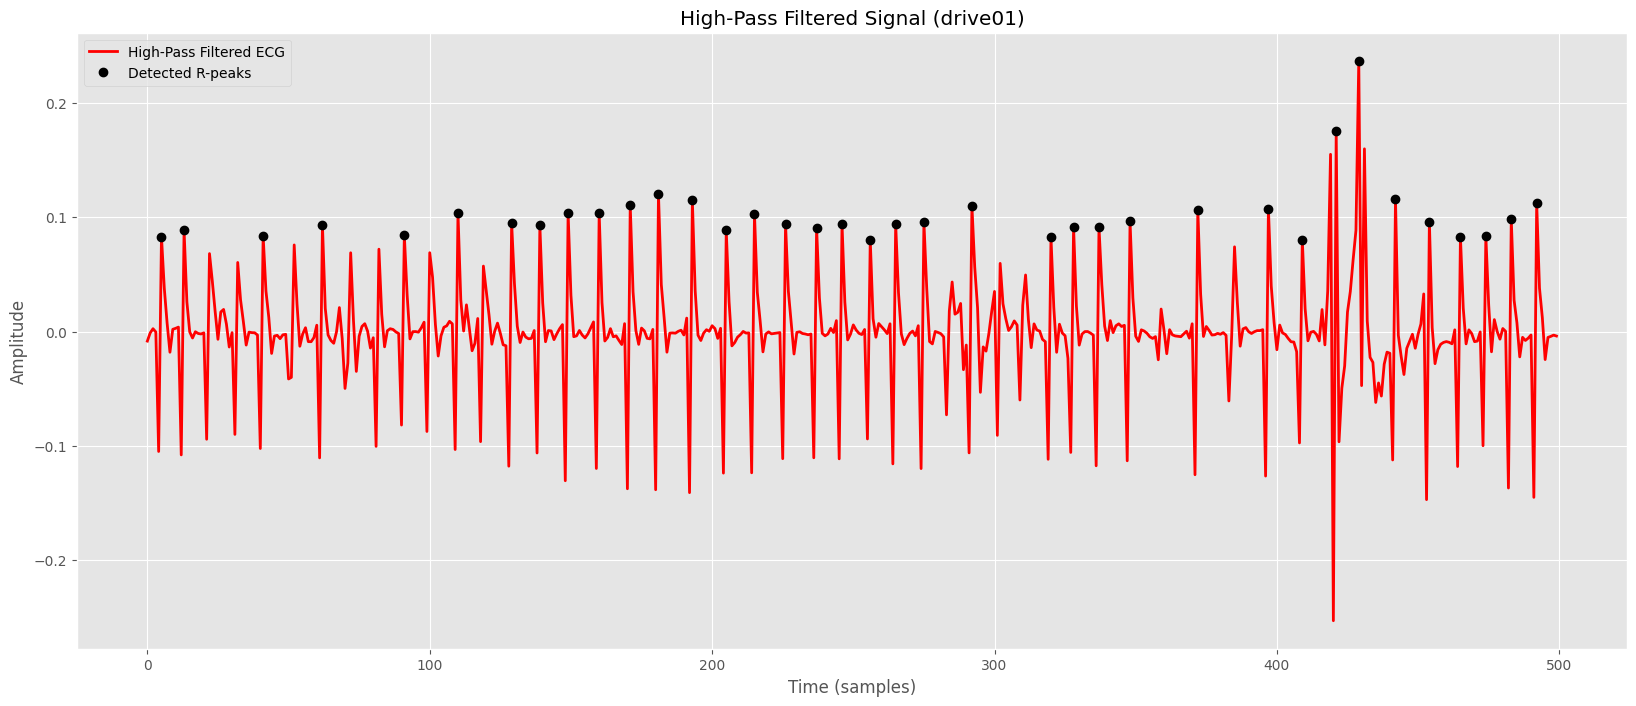

In [314]:
signal, info = get_file(n_samp=500, filter=True)
sampling_rates = info["fs"]
peaks, values = detect_peaks(signal, 92, min_distance=1)

plt.figure(figsize=(20,8))
plt.plot(signal, label='High-Pass Filtered ECG', color='red', linestyle='-', linewidth=2)
plt.plot(peaks, values, 'o', color="black", label='Detected R-peaks')
plt.title(f'High-Pass Filtered Signal (drive01)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend(loc="upper left")
plt.show()

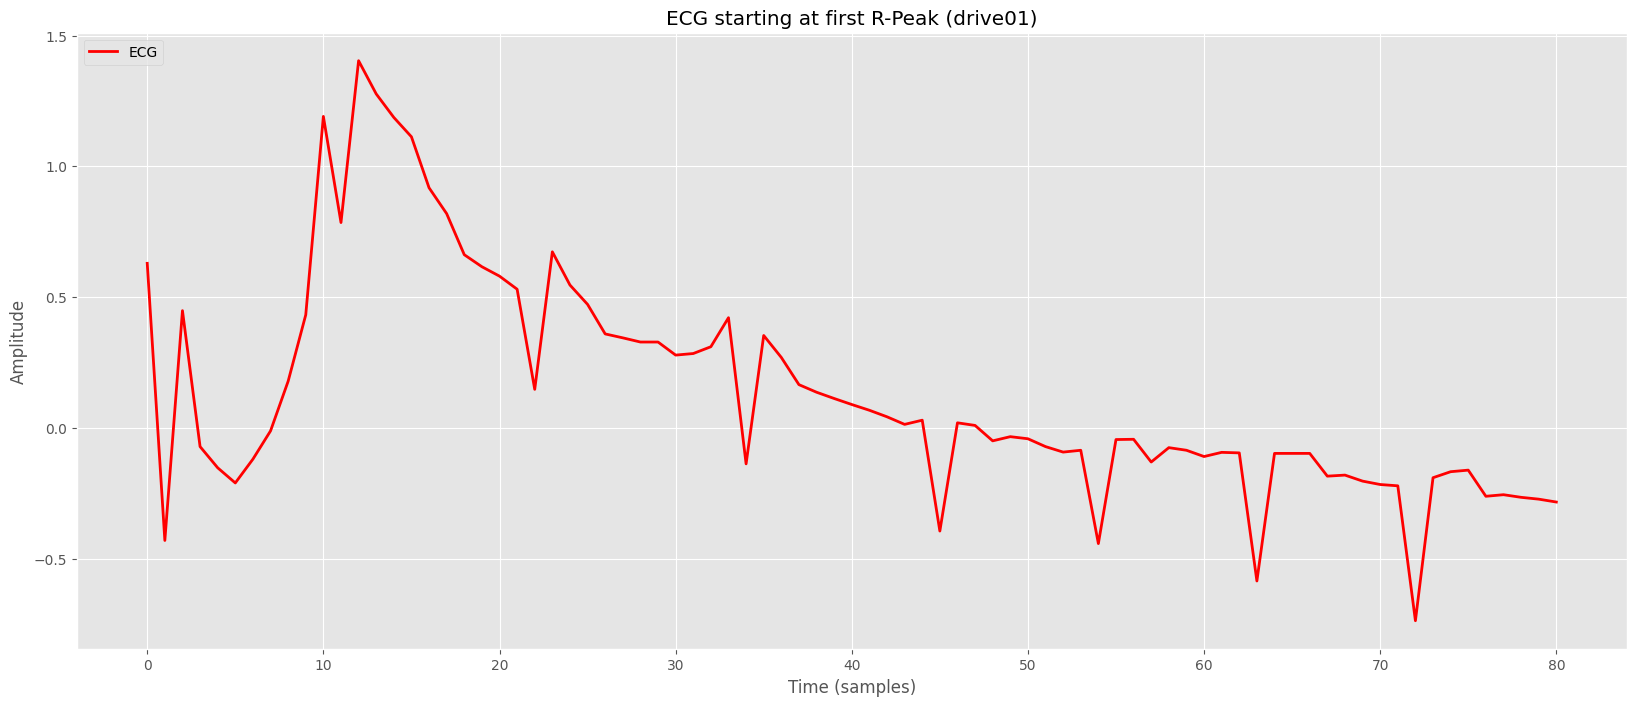

In [315]:
signals, infos = load_train_data(n_samp=500, filter=False)
sampling_rates = [signal_info["fs"] for signal_info in infos]

processed_signals = trim_to_peak(signals)

plt.figure(figsize=(20,8))
plt.plot(processed_signals[0], label='ECG', color='red', linestyle='-', linewidth=2)
plt.title(f'ECG starting at first R-Peak (drive01)')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend(loc="upper left")
plt.show()


Highest value in correlation matrix: 0.32099932533835346
Corresponding labels: ('drive05', 'drive17b')
Lowest value in correlation matrix: 0.0007880184681116559
Corresponding labels: ('drive01', 'drive08')


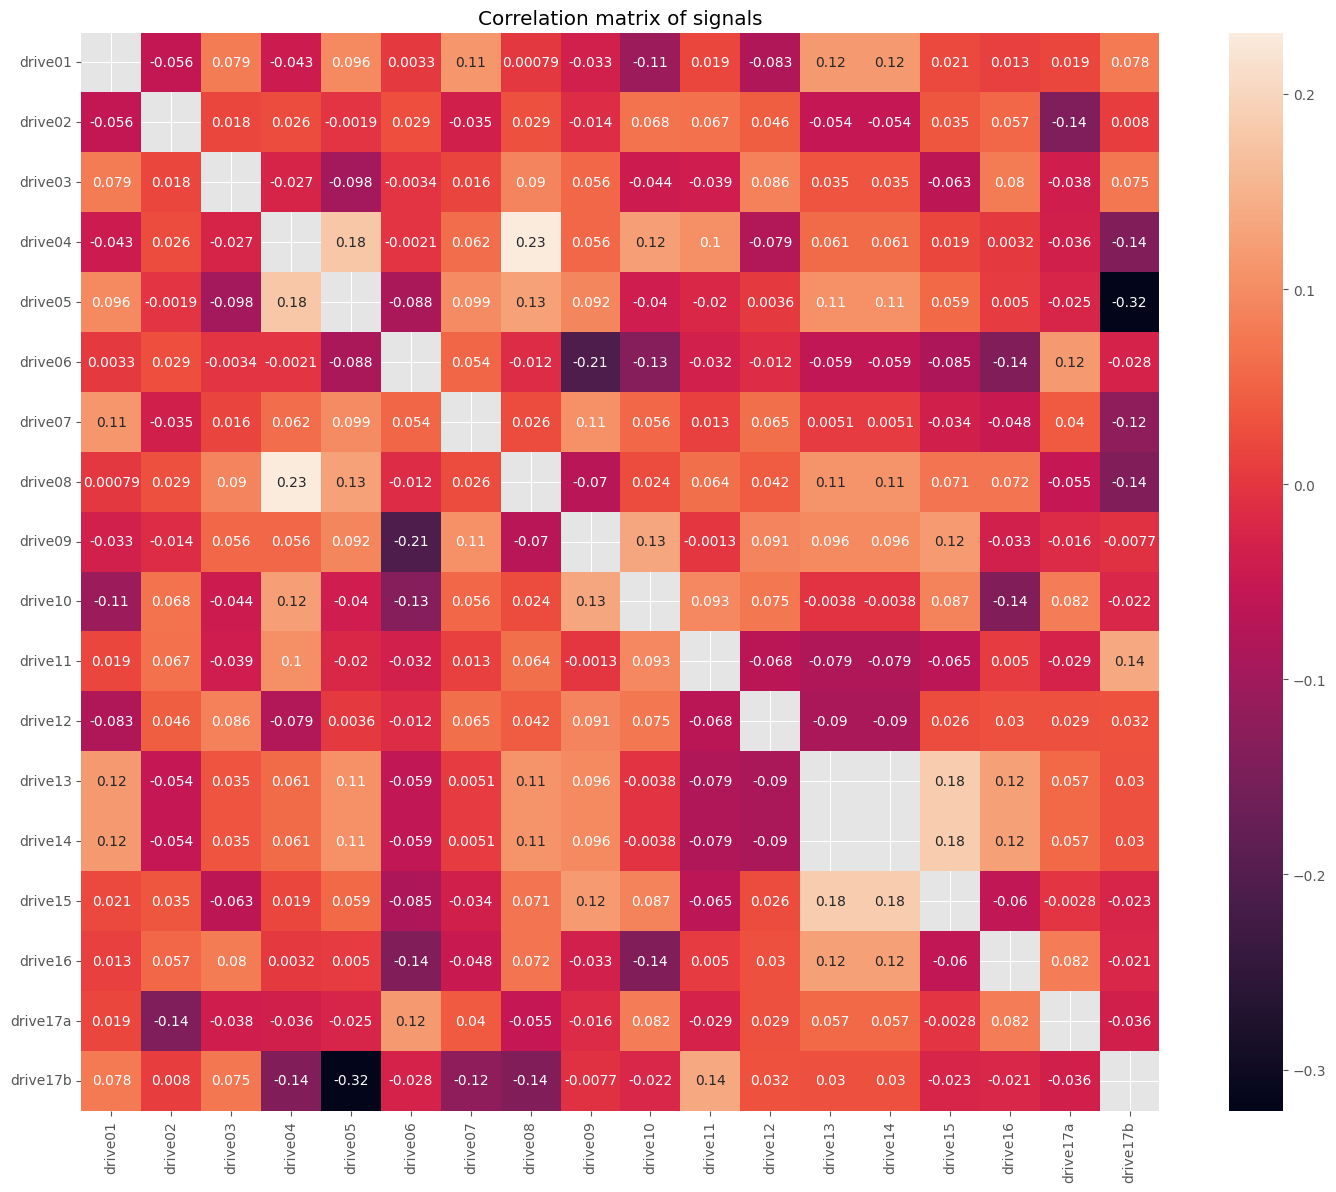

In [326]:
signals, sinfos = load_train_data(filter=False, n_samp=500)
sampling_rates = [sinfo['fs'] for sinfo in sinfos]
labels = [info['record_name'] for info in sinfos]
    
signals, highest_sr = process_signals(signals, sampling_rates)

cor_matrix = create_correlation_matrix(signals)

min_value = np.nanmin(abs(cor_matrix))
max_value = np.nanmax(abs(cor_matrix))

min_index = np.unravel_index(np.nanargmin(abs(cor_matrix)), cor_matrix.shape)
max_index = np.unravel_index(np.nanargmax(abs(cor_matrix)), cor_matrix.shape)

min_labels = (labels[min_index[0]], labels[min_index[1]])
max_labels = (labels[max_index[0]], labels[max_index[1]])

print("\nHighest value in correlation matrix:", max_value)
print("Corresponding labels:", max_labels)
print("Lowest value in correlation matrix:", min_value)
print("Corresponding labels:", min_labels)

plt.figure(figsize=(18, 14))
plt.title("Correlation matrix of signals")
sns.heatmap(cor_matrix, annot=True, xticklabels=labels, yticklabels=labels, square=True)
plt.show()

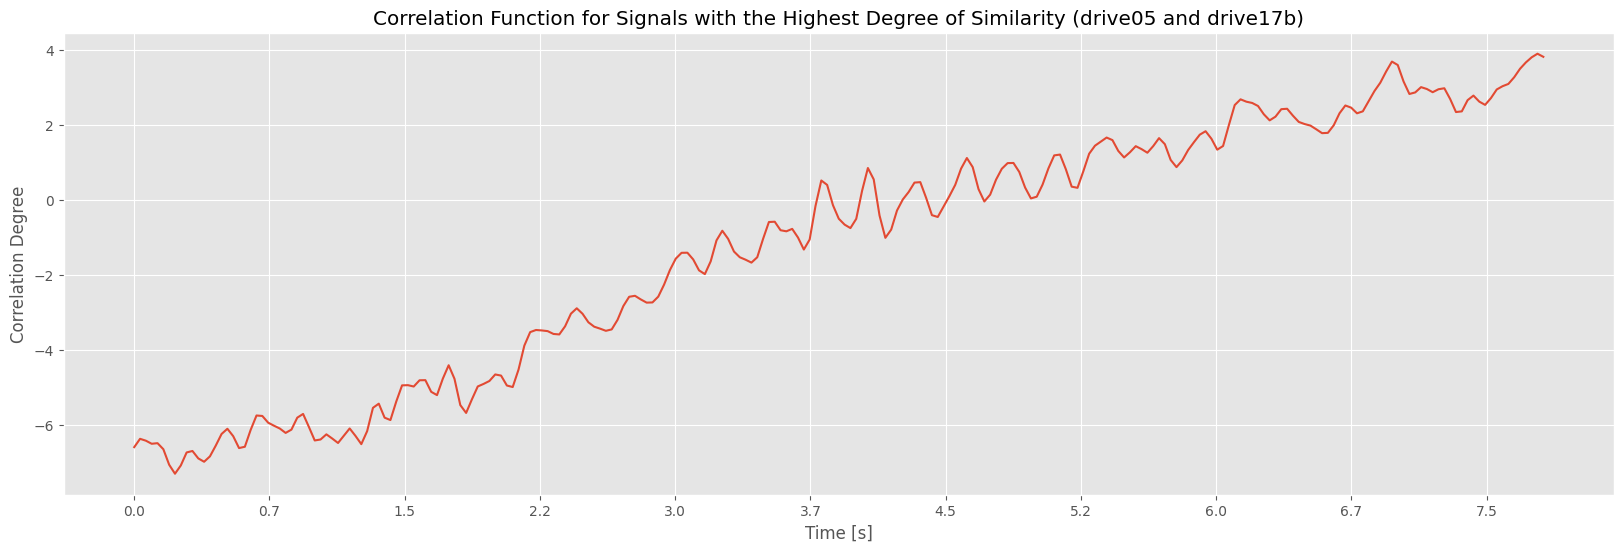

In [317]:
max_s1 = signals[max_index[0]]
max_s2 = signals[max_index[1]]
max_s1_label = labels[max_index[0]]
max_s2_label = labels[max_index[1]]

corr_signal = scipy.signal.correlate(max_s1, max_s2, mode="same")
corr_signal = np.array_split(corr_signal,2)[1]

plt.figure(figsize=(20,6))
plt.title(f"Correlation Function for Signals with the Highest Degree of Similarity ({max_s1_label} and {max_s2_label})")
plt.plot(corr_signal)
plt.ylabel("Correlation Degree")
plt.xlabel("Time [s]")
plt.xticks(np.arange(0, len(max_s1)//2, 60*12/highest_sr), np.round(np.arange(0, len(max_s1)//2, 60*12/highest_sr) / highest_sr, 1))
plt.show()


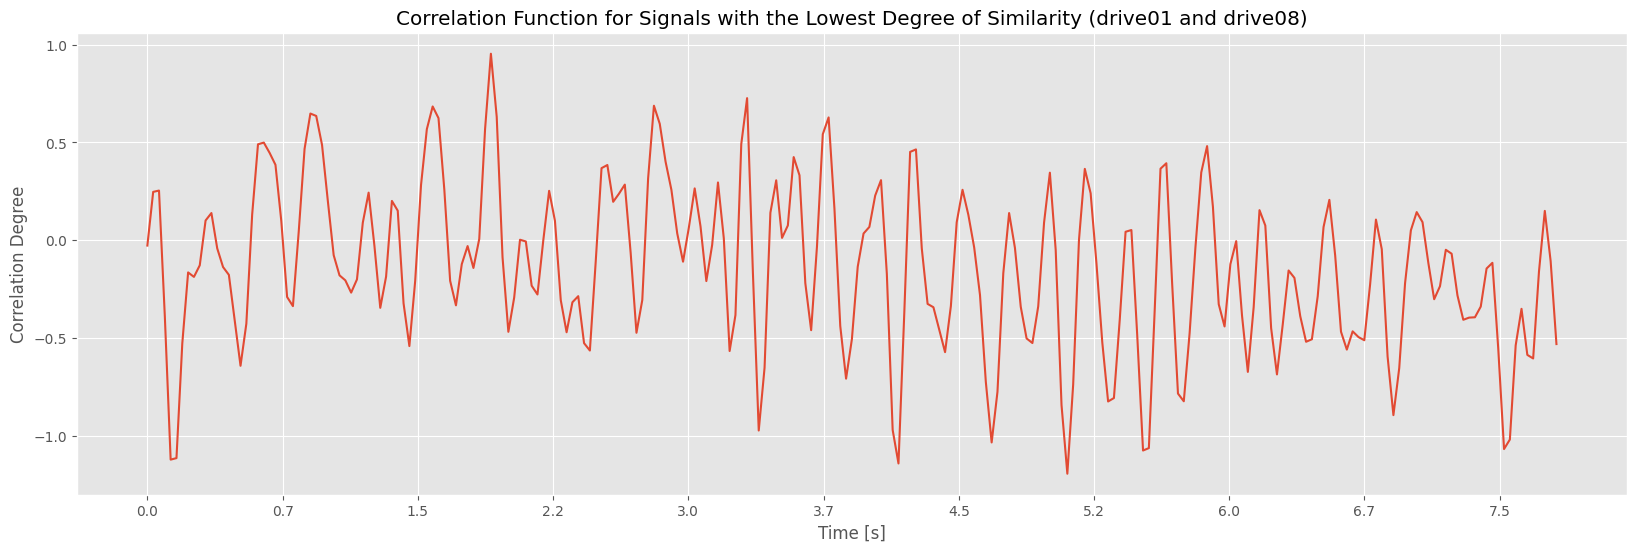

In [318]:
min_s1 = signals[min_index[0]]
min_s2 = signals[min_index[1]]
min_s1_label = labels[min_index[0]]
min_s2_label = labels[min_index[1]]

corr_signal = scipy.signal.correlate(min_s1, min_s2, mode="same")
corr_signal = np.array_split(corr_signal,2)[1]

plt.figure(figsize=(20,6))
plt.title(f"Correlation Function for Signals with the Lowest Degree of Similarity ({min_s1_label} and {min_s2_label})")
plt.plot(corr_signal)
plt.ylabel("Correlation Degree")
plt.xlabel("Time [s]")
plt.xticks(np.arange(0, len(max_s1)//2, 60*12/highest_sr), np.round(np.arange(0, len(max_s1)//2, 60*12/highest_sr) / highest_sr, 1))
plt.show()